### Exercise project 3 – Support Vector Machines
#### In this project I will use SVR = Support Vector Regression (type of
#### SVM for regression). I will use my previous regression dataset "California Housing Prices" 
#### (https://www.kaggle.com/datasets/camnugent/california-housing-prices). 
#### The cleaning/optimisation phase is copied from Project_1, so you can scrow down straight to "scale of  the regression target for SVR" phase. Target variable: "median house value". The cleaning phase copied from Project_1

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
 # load data 
df = pd.read_csv("housing.csv")

In [17]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Cleaning up the dataset (the same steps were implemented in Project_1, so I will just include the cleaning code here without comments, as it was already explained earlier)

In [18]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [19]:
df = df.dropna(axis=0)

In [20]:
df = df.drop(["latitude","longitude"], axis=1)

In [21]:
# use of OneHotEncoder:
from sklearn.preprocessing import OneHotEncoder
variables = ["ocean_proximity"]
             
# use encoder:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [22]:
df = df.drop("ocean_proximity_ISLAND", axis=1)

In [23]:
# we will use quantiles to remove the top % in order to get closer to normal distribution
df = df.query("median_house_value < median_house_value.quantile(0.93)")
df = df.query("median_income < median_income.quantile(0.99)")
df = df.query("total_rooms < total_rooms.quantile(0.97)")
df = df.query("total_bedrooms < total_bedrooms.quantile(0.98)")

In [24]:
# The same amount of rows as in Project_1 after cleaning the data.
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000,17879.000000
mean,29.004419,2262.543207,470.680799,1283.719224,440.067174,3.552390,182881.419319,0.432854,0.337882,0.104536,0.124560
std,12.267511,1254.595760,251.947257,731.908489,233.987980,1.419586,87606.683877,0.495485,0.473001,0.305963,0.330228
min,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1400.500000,291.000000,782.000000,276.000000,2.481250,112900.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,2024.000000,422.000000,1148.000000,397.000000,3.375000,168200.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,2892.500000,607.000000,1643.000000,567.000000,4.453750,237500.000000,1.000000,1.000000,0.000000,0.000000
max,52.000000,7436.000000,1311.000000,8733.000000,1295.000000,7.877400,431600.000000,1.000000,1.000000,1.000000,1.000000


#### Scale the regression target for SVR:

In [25]:
# initalize scaler
scalerY = MinMaxScaler()

# name of target variable
target_variable = "median_house_value"

# save min/max -values of target value
# for bettermetrics later
min_y = df[target_variable].min()
max_y = df[target_variable].max()

# scale y-variable
num_vars = [target_variable]
df[num_vars] = scalerY.fit_transform(df[num_vars])

####  Train/test split

In [26]:
# first, we split into X and y
# in other words, we split the dataset into support variables (X)
# and the target variable (y)

# X = list of all support variables you want to use
# while predicting the target variable with your model

# a small trick => use everything else except, the target
X = df.drop("median_house_value", axis=1)

# our target variable is y
y = df['median_house_value']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Finding optimal SVM parameters -> GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV

# initialize testable parameters
# NOTE! all algorithms do not support all parameters
# see notes below which you can use with which
param_grid = {
    'C': [0.1, 0.25, 0.5, 1, 1.25, 1.5],
    'epsilon': [0.075, 0.1, 0.125],
    'gamma': [1, 0.25, 0.1, 0.05, 0.01], 
    'kernel': ['rbf']
}

# start finding the optimal parameters with GridSearchCV!
test_model = GridSearchCV(svm.SVR(), param_grid, verbose=3)
test_model.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END C=0.1, epsilon=0.075, gamma=1, kernel=rbf;, score=-0.018 total time=   2.9s
[CV 2/5] END C=0.1, epsilon=0.075, gamma=1, kernel=rbf;, score=-0.007 total time=   2.9s
[CV 3/5] END C=0.1, epsilon=0.075, gamma=1, kernel=rbf;, score=-0.012 total time=   2.9s
[CV 4/5] END C=0.1, epsilon=0.075, gamma=1, kernel=rbf;, score=-0.006 total time=   2.8s
[CV 5/5] END C=0.1, epsilon=0.075, gamma=1, kernel=rbf;, score=-0.007 total time=   2.8s
[CV 1/5] END C=0.1, epsilon=0.075, gamma=0.25, kernel=rbf;, score=-0.018 total time=   2.8s
[CV 2/5] END C=0.1, epsilon=0.075, gamma=0.25, kernel=rbf;, score=-0.007 total time=   2.8s
[CV 3/5] END C=0.1, epsilon=0.075, gamma=0.25, kernel=rbf;, score=-0.012 total time=   2.8s
[CV 4/5] END C=0.1, epsilon=0.075, gamma=0.25, kernel=rbf;, score=-0.006 total time=   2.8s
[CV 5/5] END C=0.1, epsilon=0.075, gamma=0.25, kernel=rbf;, score=-0.007 total time=   2.8s
[CV 1/5] END C=0.1, epsilon=0.075

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 0.25, 0.5, 1, 1.25, 1.5],
                         'epsilon': [0.075, 0.1, 0.125],
                         'gamma': [1, 0.25, 0.1, 0.05, 0.01],
                         'kernel': ['rbf']},
             verbose=3)

In [29]:
# print the best combination of the parameters
test_model.best_params_

{'C': 0.25, 'epsilon': 0.075, 'gamma': 0.01, 'kernel': 'rbf'}

#### kernel - poly took too much time on my laptop; 'rbf' - 34 min.

### Training with use of the optimal parameters:

In [30]:
 # create an empty linear regression model
# and fit it with our data (fit => start training with the data)
# {'C': 0.5, 'epsilon': 0.075, 'gamma': 0.1, 'kernel': 'rbf'}
model = make_pipeline(StandardScaler(), svm.SVR(C=0.25, gamma=0.01, epsilon=0.075, kernel='rbf'))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.25, epsilon=0.075, gamma=0.01))])

 ### Error and performance metrics

In [31]:
# create test predictions based on the earlier test dataset
# we reserved out from the original dataset 
# this data has never been seen by the model by now
predictions = model.predict(X_test)

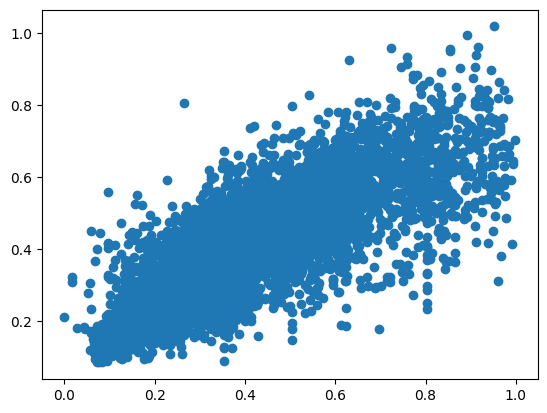

In [32]:
# let's plot how far the predictions are from the real true y-values
# in the test dataset

# if these values follow a diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
plt.scatter(y_test, predictions)
plt.show()

In [34]:
# NOTE! Change the units so that they match with your dataset's target variable
# for example, if your model is predicting Centigrades (C), don't use $-signs 
# in the metrics

# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, predictions), 2), " u$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, predictions), 2))

# otherwise metrics as usual, but add this:
# convert RMSE to original value range
print("\nRMSE in original value range ($):")
print(round(np.sqrt(metrics.mean_squared_error(y_test, predictions)) * (max_y - min_y), 2))

MAE
0.09  u$

MSE
0.02 $^2

RMSE:
0.12 $

R-squared:
0.66

RMSE in original value range ($):
51518.65


In [36]:
 # OPTIONAL! But this might be useful when you want to compare
# how off the model is in a relative sense

# basically calculate the error value divided by average target variable value

mae_percentage = metrics.mean_absolute_error(y_test, predictions) / df['median_house_value'].mean()
mae_percentage = round(mae_percentage, 2) * 100
print(f"MAE difference in % towards average: {mae_percentage} %")

rmse_percentage = np.sqrt(metrics.mean_squared_error(y_test, predictions)) / df['median_house_value'].mean()
rmse_percentage = round(rmse_percentage, 2) * 100
print(f"RMSE difference in % towards average: {rmse_percentage} %")

MAE difference in % towards average: 23.0 %
RMSE difference in % towards average: 31.0 %


C:\Users\svetl\AppData\Local\Temp\ipykernel_17324\3920156057.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions))


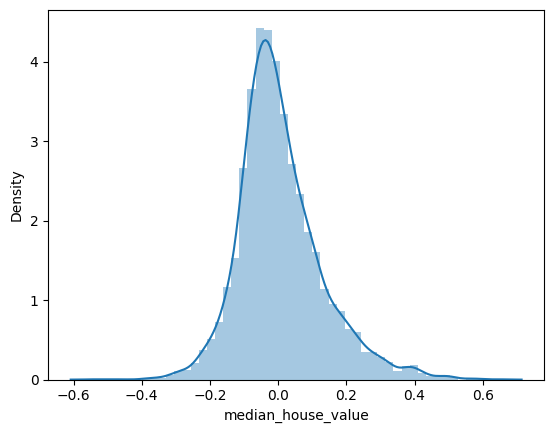

In [37]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - predictions))
plt.show()
plt.close()

### Testing the model:

In [38]:
# usually in a GUI application
# we save the earlier model-object into a file (using joblib-module)
# and in a separate GUI-application => we load up the saved model from the file
# and use the model just like here below:

# map all the variables from the user
# into a Python dictionary
# the variable names have to match with the original dataset
tester_row = {
    "housing_median_age": 50,
    "total_rooms": 500,
    "total_bedrooms": 70,
    "population": 300,
    "households": 50,	
    "median_income": 8.4567, 
    "ocean_proximity_<1H OCEAN": 1,
    "ocean_proximity_INLAND": 0,
    "ocean_proximity_NEAR BAY": 0,
    "ocean_proximity_NEAR OCEAN": 0,
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [40]:
# To get the result in dollars, i will to include a function:
result = model.predict(tester_row)[0]

# This is a function to convert scaled to dollar value
def convert_scaled_to_dollars(scaled_value, min_val, max_val):
    return scaled_value * (max_val - min_val) + min_val

# Convert the prediction
dollar_result = convert_scaled_to_dollars(result, min_y, max_y)

# Print both scaled and dollar values
print()
print(f"Predicted house price with given parameters:")
print(f"Scaled value: {round(float(result), 4)}")
print(f"In dollars: ${round(float(dollar_result), 2)}")
print("----------------")


Predicted house price with given parameters:
Scaled value: 0.8516
In dollars: $369764.97
----------------


#### Linear_regression_model -> R-squared: 0.6
#### We got not so great result. I will check result using another kernel parameters.
#### Use both StandardScaler + SVR in GridSearchCV - R-squared:0.69, Predicted house price:$261223.19
#### The better the R-squared, the lower the predicted house price. That shouldn't be the case.


In [ ]:
# I tried also the following parameters:
#param_grid = {
#    'svr__C': [0.1, 1, 10],
#    'svr__epsilon': [0.01, 0.1, 0.2],
#    'svr__gamma': ['scale', 0.01, 0.1, 1],
#    'svr__kernel': ['rbf'],
#    'svr__tol': [1e-3, 1e-4]
#}
#pipe = Pipeline([
#    ('scaler', StandardScaler()),
#    ('svr', svm.SVR())
#])

# start finding the optimal parameters with GridSearchCV!
#test_model = GridSearchCV(pipe, param_grid, verbose=3, n_jobs=-1, cv=5)
#test_model.fit(X_train, y_train)

# the final result using these parameters:
# R-squared:
# 0.68
# Predicted house price with given parameters:
# Scaled value: 0.6632
# In dollars: $291290.09



#### Comparing models SVR and Linear Regression. why SVR  predicts lower house prices than Linear Regression? ;aybe because my training data doesn’t have high-value houses (I deleted them), so SVR will likely pull predictions down, because SMR, especially RBF kernel, can flatten out extreme predictions to avoid overfitting.